In [4]:
import pickle
import os
import numpy as np
import pandas as pd

In [13]:
# load stats
# stats_path = os.path.abspath("out/2025-08-03_11:39:00/stats.pkl") # 2 robots, ~100 steps, no collisins
print(os.getcwd())
stats_path = "./out/2025-08-05_02:28:48/stats.pkl"# "out/2025-08-03_13:57:29/stats.pkl" # 32 robots, ~100 steps, no collisins
with open(stats_path, 'rb') as f:
    stats = pickle.load(f)

if stats_path == "./out/2025-08-05_02:28:48/stats.pkl":
    task_type =  "CBSMP1"
    n_agents = 48 # number of agents in the experiment
    all_agents_step_time = 1.4 # measured in seconds during the experiment
    agent_step_time = all_agents_step_time/n_agents
else:
    raise ValueError(f"Invalid stats path: {stats_path}")

/mnt/new_home/evrond/rl_for_curobo/projects_root/experiments


In [14]:
stats.keys()

dict_keys(['contact', 'goal_error', 'spheres'])

In [15]:
df_contact = pd.DataFrame(stats['contact'])
df_contact.columns = ['tstep', 'contact']  

df_goal_err = pd.DataFrame(stats['goal_error'])
df_goal_err.columns = ['tstep', 'goal_err']

df_spheres_raw = pd.DataFrame(stats['spheres'])
n_robots = len(df_spheres_raw[1][0])
n_spheres_per_robot = [len(df_spheres_raw[1][0][i]) for i in range(n_robots)]
r_index = [i for i in range(n_robots)]
s_index = [j for  j in range(max(n_spheres_per_robot))]
df_spheres_cols = ['tstep', 'agent', 'sphere', 'x', 'y', 'z','radius']
df_spheres = pd.DataFrame(columns=df_spheres_cols)

ts_col = df_spheres_raw[0]
data_col = df_spheres_raw[1]

all_rows = [
    [int(ts_col[ts_idx]), # time step
     ts_col[ts_idx] * agent_step_time, # time in seconds
     a_idx, # agent index
     s_idx, # sphere index
     data_col[ts_idx][a_idx][s_idx][0],  # x
     data_col[ts_idx][a_idx][s_idx][1],  # y
     data_col[ts_idx][a_idx][s_idx][2],  # z
     data_col[ts_idx][a_idx][s_idx][3]]  # radius
    
    for ts_idx in range(len(ts_col)) 
    for a_idx in range(n_robots) 
    for s_idx in range(n_spheres_per_robot[a_idx]) 
]

df_spheres = pd.DataFrame(all_rows, columns=['tstep','tsec', 'agent', 'sphere', 'x', 'y', 'z', 'radius'])            
df_spheres








,tstep,tsec,agent,sphere,x,y,z,radius
0,0,0.000000,0,0,0.199951,0.000000,0.0,0.026001
1,0,0.000000,0,1,0.199951,0.000000,0.0,0.001100
2,0,0.000000,1,0,0.000000,0.199951,0.0,0.026001
3,0,0.000000,1,1,0.000000,0.199951,0.0,0.001100
4,0,0.000000,2,0,0.399902,0.000000,0.0,0.026001
...,...,...,...,...,...,...,...,...
6043,310,9.041667,45,1,3.953125,4.601562,0.0,0.001100
6044,310,9.041667,46,0,4.832031,3.982422,0.0,0.026001
6045,310,9.041667,46,1,4.832031,3.982422,0.0,0.001100
6046,310,9.041667,47,0,3.949219,4.820312,0.0,0.026001


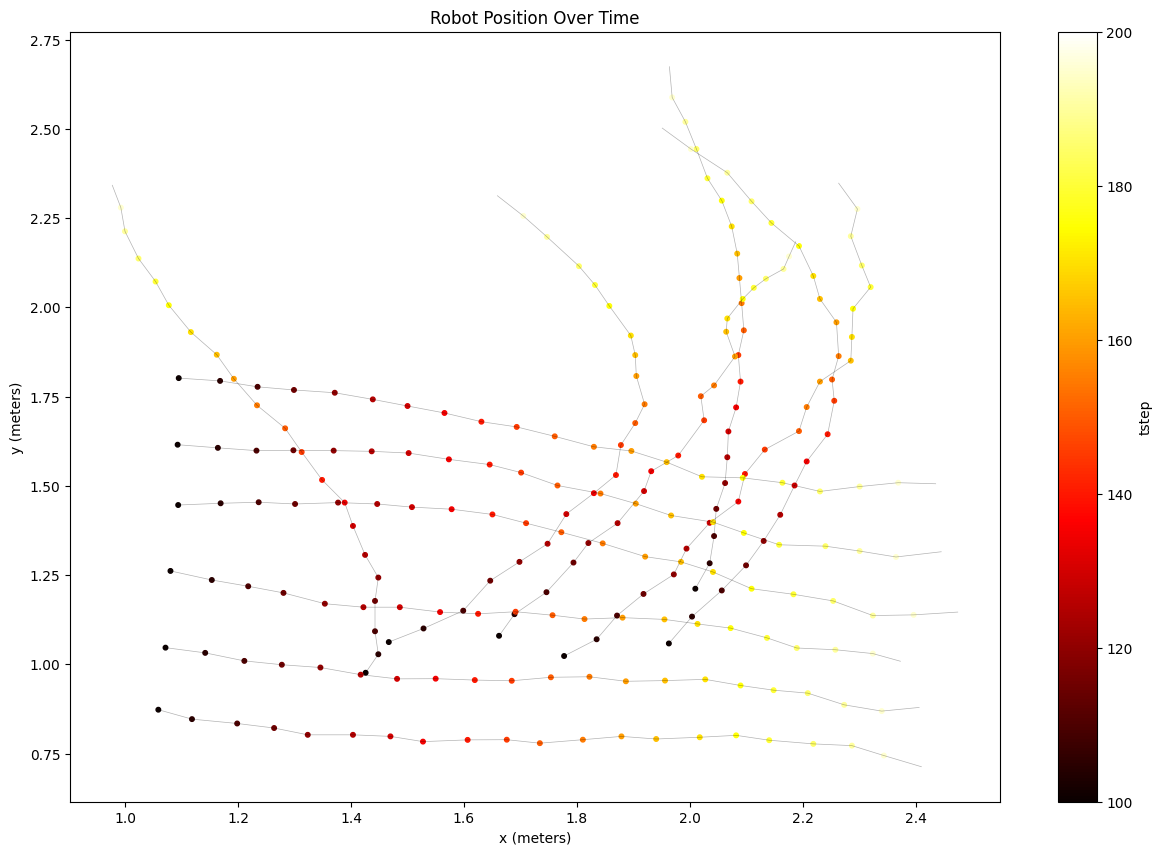

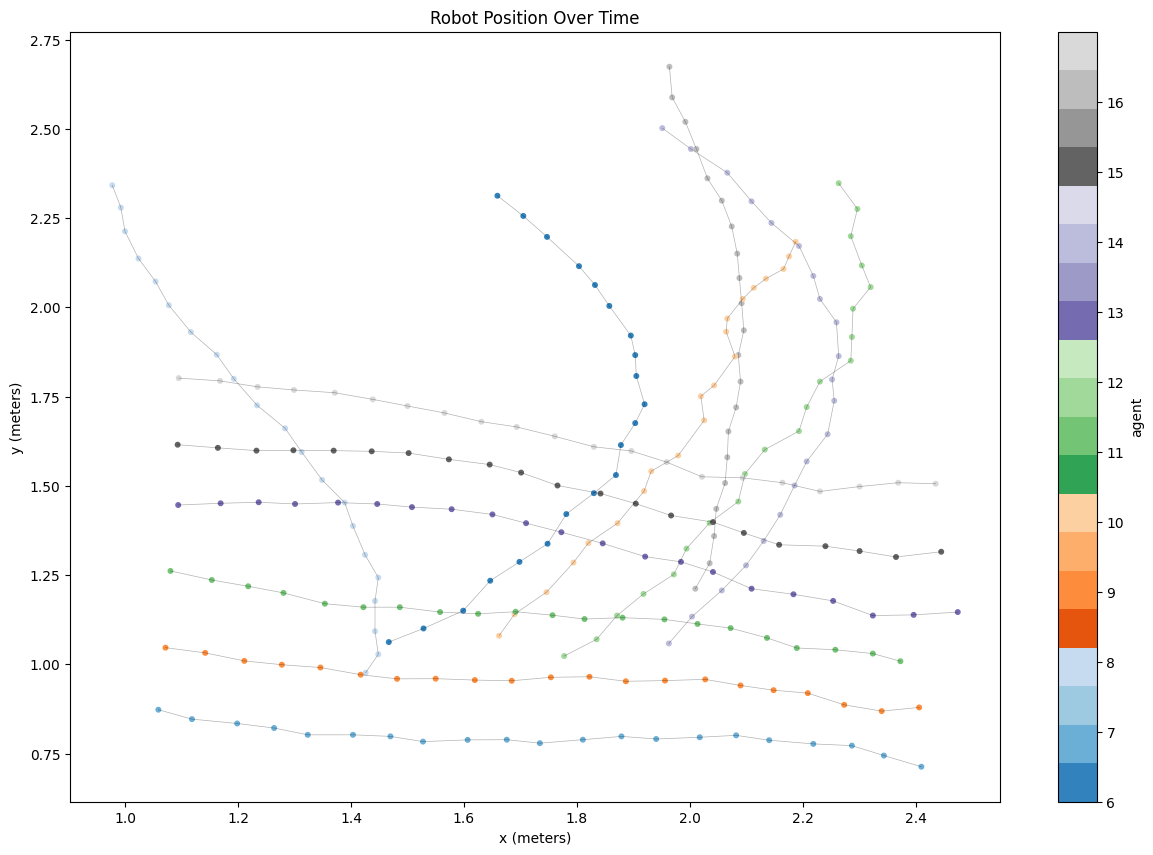

: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

time_focus = None #[100,200]# None # [100,200]
agent_focus = None # list(range(4,15))
area_focus_x = None # [1.0,3.0] # [0.01,0.02]
area_focus_y = None # [1.0,3.0] # [0.01,0.02]

def plot_spheres_over_time(df_spheres, dims=3, color_by='tstep', cmap='viridis', scale_factor=5000,tick_colorbar=-1):
    if dims in [2,3]:
        fig = plt.figure(figsize=(15, 10))
        if time_focus is not None:
            df_show = df_spheres[df_spheres['tstep'] >= time_focus[0]]
            df_show = df_show[df_show['tstep'] <= time_focus[1]]
        else:
            df_show = df_spheres

        if agent_focus is not None:
            df_show = df_show[df_show['agent'].isin(agent_focus)]
        
        if area_focus_x is not None:
            df_show = df_show[df_show['x'] >= area_focus_x[0]]
            df_show = df_show[df_show['x'] <= area_focus_x[1]]
        if area_focus_y is not None:
            df_show = df_show[df_show['y'] >= area_focus_y[0]]
            df_show = df_show[df_show['y'] <= area_focus_y[1]]
        
        if dims == 3:
            ax = fig.add_subplot(111, projection='3d')
            areas = np.pi * (df_show['radius'] ** 2) * scale_factor
            scatter = ax.scatter(df_show['x'], df_show['y'], df_show['z'], 
                            c=df_show[color_by], cmap=cmap, s=areas)
            
        elif dims == 2:
            ax = fig.add_subplot(111)
            areas = np.pi * (df_show['radius'] ** 2) * scale_factor
            scatter = ax.scatter(df_show['x'], df_show['y'], 
                            c=df_show[color_by], cmap=cmap, s=areas)
        
        
        # Connect lines between points within the same agent to 
        # better visualize the trajectory
        unique_values = sorted(df_show['agent'].unique())
        for value in unique_values:
            # Get data for this specific value, sorted by time
            value_data = df_show[df_show['agent'] == value].sort_values('tstep')
            
            if len(value_data) > 1:  # Only draw lines if there are at least 2 points
                if dims == 3:
                    ax.plot(value_data['x'], value_data['y'], value_data['z'],
                           color='black', alpha=0.3, linewidth=0.5)
                else:
                    ax.plot(value_data['x'], value_data['y'],
                           color='black', alpha=0.3, linewidth=0.5)
        
        
        ax.set_title('Robot Position Over Time')
        ax.set_xlabel('x (meters)')
        ax.set_ylabel('y (meters)')
        
        ticks = None # default ticks
        if tick_colorbar > 0: 
            tick_min = df_show[color_by].min()
            tick_max = df_show[color_by].max()
            ticks = np.arange(tick_min, tick_max,tick_colorbar)
        
        cbar = plt.colorbar(scatter, label=color_by,ticks=ticks)
        cbar.set_label(color_by)
        
    else:
        raise ValueError(f"Invalid dimensions: {dims}")
    plt.show()

plot_spheres_over_time(df_spheres,color_by='tstep', cmap='hot',dims=2) # https://matplotlib.org/stable/gallery/color/colormap_reference.html
plot_spheres_over_time(df_spheres,color_by='agent', cmap='tab20c', dims=2, tick_colorbar=1) # https://matplotlib.org/stable/gallery/color/colormap_reference.html

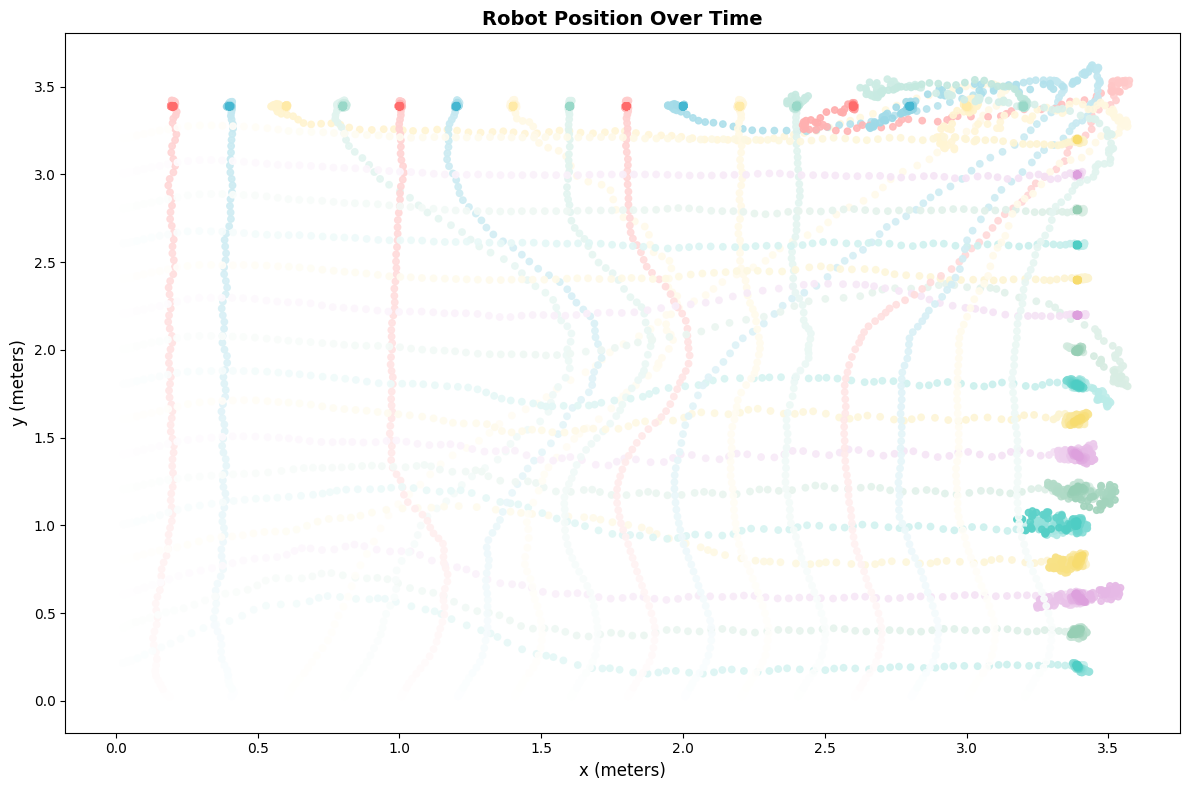

In [ ]:
# def plot_spheres_over_time(df_spheres, dims=3, scale_factor=10000):
#     if dims in [2, 3]:
#         fig = plt.figure(figsize=(12, 8))
#         if dims == 3:
#             ax = fig.add_subplot(111, projection='3d')
#         elif dims == 2:
#             ax = fig.add_subplot(111)
        
#         # Get unique agents
#         unique_agents = sorted(df_spheres['agent'].unique())
        
#         # Define distinct colors for each robot
#         colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8', '#F7DC6F']
        
#         for i, agent in enumerate(unique_agents):
#             # Get data for this agent
#             agent_data = df_spheres[df_spheres['agent'] == agent]
            
#             # Normalize time steps for this agent (0 to 1)
#             agent_data = agent_data.copy()
#             agent_data['normalized_time'] = (agent_data['tstep'] - agent_data['tstep'].min()) / (agent_data['tstep'].max() - agent_data['tstep'].min())
            
#             # Create color gradient from transparent to full color
#             base_color = colors[i % len(colors)]
            
#             # Create custom colormap: transparent -> base_color
#             from matplotlib.colors import LinearSegmentedColormap
#             cmap = LinearSegmentedColormap.from_list(f'agent_{agent}', ['white', base_color], N=100)
            
#             # Calculate areas
#             areas = np.pi * (agent_data['radius'] ** 2) * scale_factor
            
#             # Plot this agent's data
#             if dims == 3:
#                 scatter = ax.scatter(agent_data['x'], agent_data['y'], agent_data['z'],
#                                    c=agent_data['normalized_time'], cmap=cmap, s=areas,
#                                    alpha=0.7, label=f'Robot {agent}')
#             else:
#                 scatter = ax.scatter(agent_data['x'], agent_data['y'],
#                                    c=agent_data['normalized_time'], cmap=cmap, s=areas,
#                                    alpha=0.9, label=f'Robot {agent}')
        
#         ax.set_title('Robot Position Over Time', fontsize=14, fontweight='bold')
#         ax.set_xlabel('x (meters)', fontsize=12)
#         ax.set_ylabel('y (meters)', fontsize=12)
#         if dims == 3:
#             ax.set_zlabel('z (meters)', fontsize=12)
        
#         # Add legend
#         # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
#         plt.tight_layout()
        
#     else:
#         raise ValueError(f"Invalid dimensions: {dims}")
#     plt.show()

# plot_spheres_over_time(df_spheres, dims=2)

In [ ]:
df_goal_err = pd.DataFrame(stats['goal_error'])
df_goal_err[1][0]


In [128]:
df_contact[0]
df_contact.loc[0]

KeyError: 0